In [423]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

In [424]:
# Load the datasets
epidemiological_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')


In [425]:
# Convert the date columns to datetime format for all datasets
epidemiological_data['date_symptom_onset2'] = pd.to_datetime(epidemiological_data['date_symptom_onset2'], errors='coerce')
climatic_data['date'] = pd.to_datetime(climatic_data['date'], format='%Y%m%d', errors='coerce')
# Explicitly specify the format for mobility data if it's in DD/MM/YYYY format
mobility_data['date'] = pd.to_datetime(mobility_data['date'], format='%d/%m/%Y', errors='coerce')

In [426]:
# Select relevant columns for merging (with added climate and mobility variables)
epidemiological_data_relevant = epidemiological_data[[
    'Stateofresidence_updated', 'date_symptom_onset2', 'case_classification_recode', 
    'age_recode', 'sex_new2', 'pregnancy_new', 'contact_with_source_case_new', 
    'direct_contact_probable_case', 'rodents_excreta', 'fever_new'
]].copy()

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation', 
                                        'wind_speed', 'solar_radiation', 'surface_pressure', 'dew_point']].copy()

mobility_data_relevant = mobility_data[['sub_region_1', 'date', 'workplaces_percent_change_from_baseline', 
                                        'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 
                                        'retail_and_recreation_percent_change_from_baseline', 
                                        'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline']].copy()

In [427]:
#Handling missing values
epidemiological_data_relevant['date_symptom_onset2'].fillna(method='ffill', inplace=True)  # Forward fill
epidemiological_data_relevant['sex_new2'].fillna('Unknown', inplace=True)


In [428]:
# Rename columns for merging consistency
epidemiological_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date' }, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

# Merging datasets based on 'state' and 'date'
combined_data = epidemiological_data_relevant.merge(climatic_data_relevant, on=['state', 'date'], how='left')
combined_data = combined_data.merge(mobility_data_relevant, on=['state', 'date'], how='left')

In [429]:
combined_data.tail()

,state,date,case_classification_recode,age_recode,sex_new2,pregnancy_new,contact_with_source_case_new,direct_contact_probable_case,rodents_excreta,fever_new,...,wind_speed,solar_radiation,surface_pressure,dew_point,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,transit_stations_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline
62903,Ondo,2017-12-28,positive,32,2.0,NaN,NaN,NaN,NaN,Yes,...,2.38,4.46,96.75,15.58,NaN,NaN,NaN,NaN,NaN,NaN
62904,Taraba,2017-12-30,positive,18,1.0,NaN,NaN,NaN,NaN,Yes,...,4.75,6.06,98.35,6.41,NaN,NaN,NaN,NaN,NaN,NaN
62905,Taraba,2017-12-28,positive,16,2.0,NaN,NaN,NaN,NaN,Yes,...,3.87,5.74,98.16,7.05,NaN,NaN,NaN,NaN,NaN,NaN
62906,Taraba,2020-03-27,negative,45,2.0,NaN,NaN,NaN,NaN,Yes,...,2.91,5.48,97.93,18.51,-10.0,NaN,NaN,16.0,NaN,NaN
62907,Taraba,2020-03-27,negative,45,2.0,NaN,NaN,NaN,NaN,Yes,...,2.91,5.48,97.93,18.51,-13.0,NaN,NaN,NaN,NaN,NaN


In [430]:
print(combined_data.shape)

(62908, 23)


In [431]:
# Check for missing values in each column
print(combined_data.isnull().sum())

state                                                     0
date                                                      0
case_classification_recode                               68
age_recode                                                0
sex_new2                                                  0
pregnancy_new                                         54367
contact_with_source_case_new                          49429
direct_contact_probable_case                          27370
rodents_excreta                                       27202
fever_new                                              5884
temperature                                             180
humidity                                                180
precipitation                                           180
wind_speed                                              180
solar_radiation                                         180
surface_pressure                                        180
dew_point                               

In [432]:
# Impute missing values in 'pregnancy_new' with the mode
combined_data['pregnancy_new'].fillna(combined_data['pregnancy_new'].mode()[0], inplace=True)

# Impute missing values in 'pregnancy_new' with the mode
combined_data['case_classification_recode'].fillna(combined_data['case_classification_recode'].mode()[0], inplace=True)

# Impute missing values in 'direct_contact_probable_case' with "NO"
combined_data['direct_contact_probable_case'].fillna('UNKNOWN', inplace=True)

# Add 'UNKNOWN' as a new category to the categorical column
combined_data['contact_with_source_case_new'] = combined_data['contact_with_source_case_new'].cat.add_categories(['UNKNOWN'])

# Now fill missing values with 'UNKNOWN'
combined_data['contact_with_source_case_new'].fillna('UNKNOWN', inplace=True)

# Impute missing values in 'rodents_excreta' with "NO"
combined_data['rodents_excreta'].fillna('UNKNOWN', inplace=True)

# Impute missing values in 'workplaces_percent_change_from_baseline' with the mean
combined_data['workplaces_percent_change_from_baseline'].fillna(combined_data['workplaces_percent_change_from_baseline'].mean(), inplace=True)

# Impute missing values in 'residential_percent_change_from_baseline' with the mean
combined_data['residential_percent_change_from_baseline'].fillna(combined_data['residential_percent_change_from_baseline'].mean(), inplace=True)

# Impute missing values in 'transit_stations_percent_change_from_baseline' with the mean
combined_data['transit_stations_percent_change_from_baseline'].fillna(combined_data['transit_stations_percent_change_from_baseline'].mean(), inplace=True)

# Impute missing values in 'transit_stations_percent_change_from_baseline' with the mean
combined_data['retail_and_recreation_percent_change_from_baseline'].fillna(combined_data['retail_and_recreation_percent_change_from_baseline'].mean(), inplace=True)

# Impute missing values in 'transit_stations_percent_change_from_baseline' with the mean
combined_data['grocery_and_pharmacy_percent_change_from_baseline'].fillna(combined_data['grocery_and_pharmacy_percent_change_from_baseline'].mean(), inplace=True)

# Impute missing values in 'transit_stations_percent_change_from_baseline' with the mean
combined_data['parks_percent_change_from_baseline'].fillna(combined_data['parks_percent_change_from_baseline'].mean(), inplace=True)

combined_data = combined_data.dropna(subset=['fever_new', 'temperature', 'humidity', 'precipitation', 'wind_speed', 'solar_radiation', 'surface_pressure', 'dew_point' ])
         
# Verify that there are no missing values left
print(combined_data.isnull().sum())

state                                                 0
date                                                  0
case_classification_recode                            0
age_recode                                            0
sex_new2                                              0
pregnancy_new                                         0
contact_with_source_case_new                          0
direct_contact_probable_case                          0
rodents_excreta                                       0
fever_new                                             0
temperature                                           0
humidity                                              0
precipitation                                         0
wind_speed                                            0
solar_radiation                                       0
surface_pressure                                      0
dew_point                                             0
workplaces_percent_change_from_baseline         

In [433]:
print(combined_data.columns)

Index(['state', 'date', 'case_classification_recode', 'age_recode', 'sex_new2',
       'pregnancy_new', 'contact_with_source_case_new',
       'direct_contact_probable_case', 'rodents_excreta', 'fever_new',
       'temperature', 'humidity', 'precipitation', 'wind_speed',
       'solar_radiation', 'surface_pressure', 'dew_point',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline'],
      dtype='object')


In [434]:
# Filter for confirmed cases (assuming 1 means confirmed cases)
confirmed_cases = combined_data[combined_data['case_classification_recode'] == 1]

In [435]:
# Create daily case count by grouping by state and date
daily_case_count = confirmed_cases.groupby(['state', 'date']).size().reset_index(name='case_count')

In [436]:
print(daily_case_count)

Empty DataFrame
Columns: [state, date, case_count]
Index: []


In [325]:
# Merging the datasets on 'state' and 'date'
combined_data = daily_case_count.merge(climatic_data_relevant, on=['state', 'date'], how='inner')
combined_data = combined_data.merge(mobility_data_relevant, on=['state', 'date'], how='inner')

In [326]:
# Fill missing dates with zero case counts if necessary (optional)
combined_data = combined_data.set_index(['state', 'date']).unstack(fill_value=0).stack().reset_index()

In [328]:
print(combined_data.columns)

Index(['state', 'date'], dtype='object')


In [327]:
# Label encoding for categorical variables (e.g., 'sex_new2' in epidemiological data if required)
label_encoder = LabelEncoder()
combined_data['sex_new2'] = label_encoder.fit_transform(combined_data['sex_new2'])

KeyError: 'sex_new2'

In [ ]:

# Scaling the data (excluding 'state' and 'date')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data.drop(columns=['state', 'date']))

In [ ]:
# Convert back to DataFrame for structure
scaled_data = pd.DataFrame(scaled_data, columns=combined_data.columns.drop(['state', 'date']))

In [ ]:
# Step 1: Create sequences for the LSTM model (e.g., using 30 days of past data)
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])  # Use all features for X
        y.append(data[i + time_steps, 0])  # Assuming the first column is 'case_count'
    return np.array(X), np.array(y)

In [ ]:
# Create time-series sequences
time_steps = 30  # Using 30 past days as time steps
X, y = create_sequences(scaled_data.values, time_steps)

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [ ]:
# Step 2: Build and train the LSTM model
model = Sequential()

# LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (1 unit for predicting outbreak cases)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
# Step 3: Model evaluation
predictions = model.predict(X_test)

# Rescale predictions back to original values
predictions_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, 1:], predictions), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, 1:], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, color='blue', label='Actual Outbreak Cases')
plt.plot(predictions_rescaled, color='red', label='Predicted Outbreak Cases')
plt.title('LSTM Model - Actual vs Predicted Outbreak Cases')
plt.xlabel('Time')
plt.ylabel('Outbreak Cases')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f'Mean Squared Error: {mse}')

In [248]:
case_counts = combined_data.groupby(['state', 'date'])['case_count_column'].sum().reset_index()


KeyError: 'Column not found: case_count_column'

In [220]:
# Merge the case count back into the combined dataset
combined_data = combined_data.merge(case_counts, on=['state', 'date'], how='left')

In [221]:
print(case_counts)
print(combined_data)

        state       date  case_count
0        Abia 2018-01-11           1
1        Abia 2018-01-20           1
2        Abia 2019-01-23           1
3        Abia 2019-01-29           1
4        Abia 2019-01-30           1
...       ...        ...         ...
5918  Zamfara 2020-03-09           2
5919  Zamfara 2020-03-14           1
5920  Zamfara 2020-03-18           1
5921  Zamfara 2020-06-13           1
5922  Zamfara 2020-11-28           1

[5923 rows x 3 columns]
        state       date case_classification_recode age_recode sex_new2  \
0      Bauchi 2021-12-27                   negative          9      2.0   
1      Bauchi 2021-12-27                   negative          9      2.0   
2      Bauchi 2021-12-27                   negative          9      2.0   
3        Ondo 2021-12-27                   negative          6      1.0   
4        Ondo 2021-12-27                   negative          6      1.0   
...       ...        ...                        ...        ...      ...   
52026 

In [222]:
print(combined_data.shape)

(52031, 24)


In [223]:
# Normalize features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data[features])

KeyError: "['case_counts'] not in index"

In [224]:
# Prepare sequences for LSTM
def create_sequences(data, time_step=30):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

In [225]:
# Split into training and testing datasets
train_size = int(len(case_counts) * 0.8)
train_data = case_counts['scaled_case_count'].values[:train_size]
test_data = case_counts['scaled_case_count'].values[train_size:]

KeyError: 'scaled_case_count'

In [185]:
# Create sequences for training and testing
X_train, Y_train = create_sequences(train_data, time_step=30)
X_test, Y_test = create_sequences(test_data, time_step=30)

In [186]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [187]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # First LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training data
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

/Users/m1/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0029 - val_loss: 7.4645e-04
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 7.5598e-04
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 7.6164e-04
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 7.9754e-04
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 8.8885e-04
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 7.5540e-04
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 7.4328e-04
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 7.3719e-04
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 7.3669e-04
Epoch 10/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 7.2903e-04
Epoch 11/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 7.6623e-04
Epoc

In [188]:
# Step 4: Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual case counts
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate Mean Squared Error
train_mse = mean_squared_error(case_counts['case_count'].values[:train_size][30:], train_predict)
test_mse = mean_squared_error(case_counts['case_count'].values[train_size:][30:], test_predict)

print(f'Train Mean Squared Error: {train_mse}')
print(f'Test Mean Squared Error: {test_mse}')

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Mean Squared Error: 7.220798191454833
Test Mean Squared Error: 3.1547057512477776


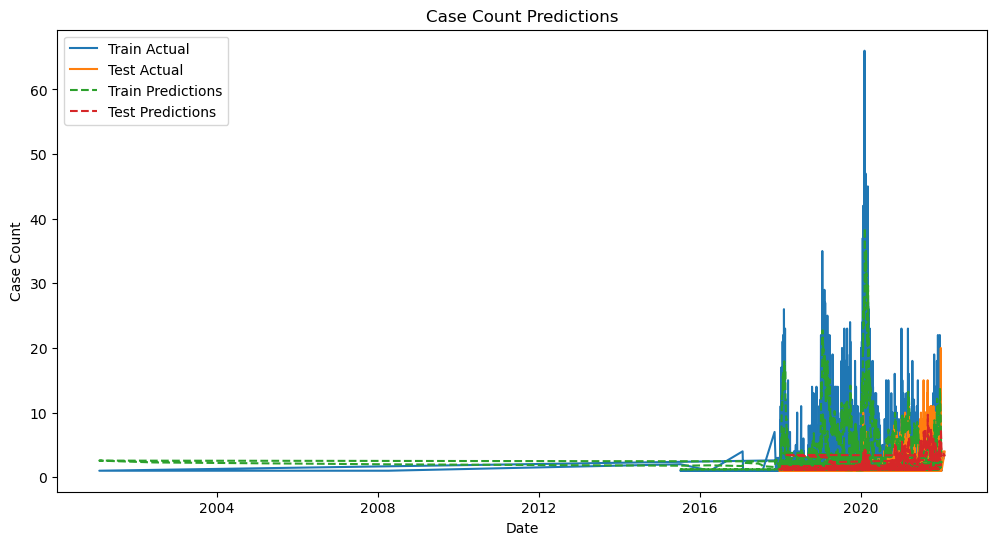

In [189]:
# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(case_counts['date'][:train_size], case_counts['case_count'][:train_size], label='Train Actual')
plt.plot(case_counts['date'][train_size:], case_counts['case_count'][train_size:], label='Test Actual')
plt.plot(case_counts['date'][30:train_size], train_predict, label='Train Predictions', linestyle='dashed')
plt.plot(case_counts['date'][train_size+30:], test_predict, label='Test Predictions', linestyle='dashed')
plt.title('Case Count Predictions')
plt.xlabel('Date')
plt.ylabel('Case Count')
plt.legend()
plt.show()